In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
%matplotlib notebook
plt.rcParams["font.sans-serif"] = ["SimHei"] #解决中文字符乱码的问题
plt.rcParams["axes.unicode_minus"] = False #正常显示负号

In [2]:
DATADIR = 'DatasetsPlus2/Train'
TESTDIR = 'DatasetsPlus2/Test'
CATEGORIES = ['Fire', 'NoFire']
IMG_SIZE = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 200
batch_size = 48
learning_rate = 0.0001
num_classes = 2
loss_list_train = []
acc_list_train = []
loss_list_test = []
acc_list_test = []
FP = 0
FN = 0
TP = 0
TN = 0
FP_list = []
FN_list = []
Recall_list = []
Precision_list = []
F_list = []

In [3]:
class FireNetTrainDataset(Dataset):
    def __init__(self):
        self.x_list = []
        self.y_list = []
        for category in CATEGORIES:
            path = os.path.join(DATADIR,category)
            class_num = CATEGORIES.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img))
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    img_tensor = transforms.ToTensor()(new_array)
                    self.x_list.append(img_tensor)
                    self.y_list.append(class_num)
                except Exception as e:
                    pass
        self.x_data = torch.stack(self.x_list)
        self.y_data = torch.tensor(self.y_list,dtype = torch.int64)
        self.length = len(self.x_data)
 
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    def __len__(self):
        return self.length
    
class FireNetTestDataset(Dataset):
    def __init__(self):
        self.x_list = []
        self.y_list = []
        for category in CATEGORIES:
            path = os.path.join(TESTDIR,category)
            class_num = CATEGORIES.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img))
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    img_tensor = transforms.ToTensor()(new_array)
                    self.x_list.append(img_tensor)
                    self.y_list.append(class_num)
                except Exception as e:
                    pass
        self.x_data = torch.stack(self.x_list)
        self.y_data = torch.tensor(self.y_list,dtype = torch.int64)
        self.length = len(self.x_data)
 
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    def __len__(self):
        return self.length

In [4]:
dataset = FireNetTrainDataset()
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = FireNetTestDataset()
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [5]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Dropout(p=0.5))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Dropout(p=0.5))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Dropout(p=0.5))
        self.layer4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 256),
            nn.ReLU(),
            nn.Dropout(p=0.4))
        self.layer5 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [6]:
model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)
for epoch in range(num_epochs):
    print("epoch : %d" %epoch)
    model.train()
    train_total = 0
    train_acc = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        train_acc += (predicted == labels).sum().item()
        train_total += labels.size(0)
        del images, labels
    train_loss = train_loss / total_step
    train_acc = train_acc / train_total
    loss_list_train.append(train_loss)
    acc_list_train.append(train_acc)
    
    model.eval()
    test_total = 0
    test_acc = 0
    test_loss = 0
    FP = 0
    FN = 0
    TP = 0
    TN = 0
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
        loss = criterion(outputs, labels)
        #predicted = torch.argmax(optputs, 1)
        predicted = torch.max(outputs.data, 1)[1]
        test_acc += (predicted == labels).sum().item()
        test_loss += loss.item()
        test_total += labels.size(0)
        
        zes=torch.zeros(labels.size(0)).type(torch.LongTensor).to(device)
        ons=torch.ones(labels.size(0)).type(torch.LongTensor).to(device)
        train_correct01 = ((predicted==zes)&(labels==ons)).sum().item() #原标签为1，预测为0
        train_correct10 = ((predicted==ons)&(labels==zes)).sum().item() #原标签为0，预测为1
        train_correct00 = ((predicted==zes)&(labels==zes)).sum().item() #原标签为0，预测为0
        train_correct11 = ((predicted==ons)&(labels==ons)).sum().item() #原标签为1，预测为0
        FP += train_correct10
        FN += train_correct01
        TP += train_correct11
        TN += train_correct00
        del images, labels
    FP_list.append(round(FP/(FP+TN+TP+FN),4))
    FN_list.append(round(FN/(TP+FN+FP+TN),4))
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    Recall_list.append(round(R,4))
    Precision_list.append(round(P,4))
    F_list.append(round(((2*P*R)/(P+R)),4))
    test_acc = test_acc / test_total
    test_loss = test_loss / len(test_loader)
    loss_list_test.append(test_loss)
    acc_list_test.append(test_acc)

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19
epoch : 20
epoch : 21
epoch : 22
epoch : 23
epoch : 24
epoch : 25
epoch : 26
epoch : 27
epoch : 28
epoch : 29
epoch : 30
epoch : 31
epoch : 32
epoch : 33
epoch : 34
epoch : 35
epoch : 36
epoch : 37
epoch : 38
epoch : 39
epoch : 40
epoch : 41
epoch : 42
epoch : 43
epoch : 44
epoch : 45
epoch : 46
epoch : 47
epoch : 48
epoch : 49
epoch : 50
epoch : 51
epoch : 52
epoch : 53
epoch : 54
epoch : 55
epoch : 56
epoch : 57
epoch : 58
epoch : 59
epoch : 60
epoch : 61
epoch : 62
epoch : 63
epoch : 64
epoch : 65
epoch : 66
epoch : 67
epoch : 68
epoch : 69
epoch : 70
epoch : 71
epoch : 72
epoch : 73
epoch : 74
epoch : 75
epoch : 76
epoch : 77
epoch : 78
epoch : 79
epoch : 80
epoch : 81
epoch : 82
epoch : 83
epoch : 84
epoch : 85
epoch : 86
epoch : 87
epoch : 88
epoch : 89
epoch : 90
epoch : 9

In [7]:
#torch.save(model, 'Model/V1.pth')

<IPython.core.display.Javascript object>


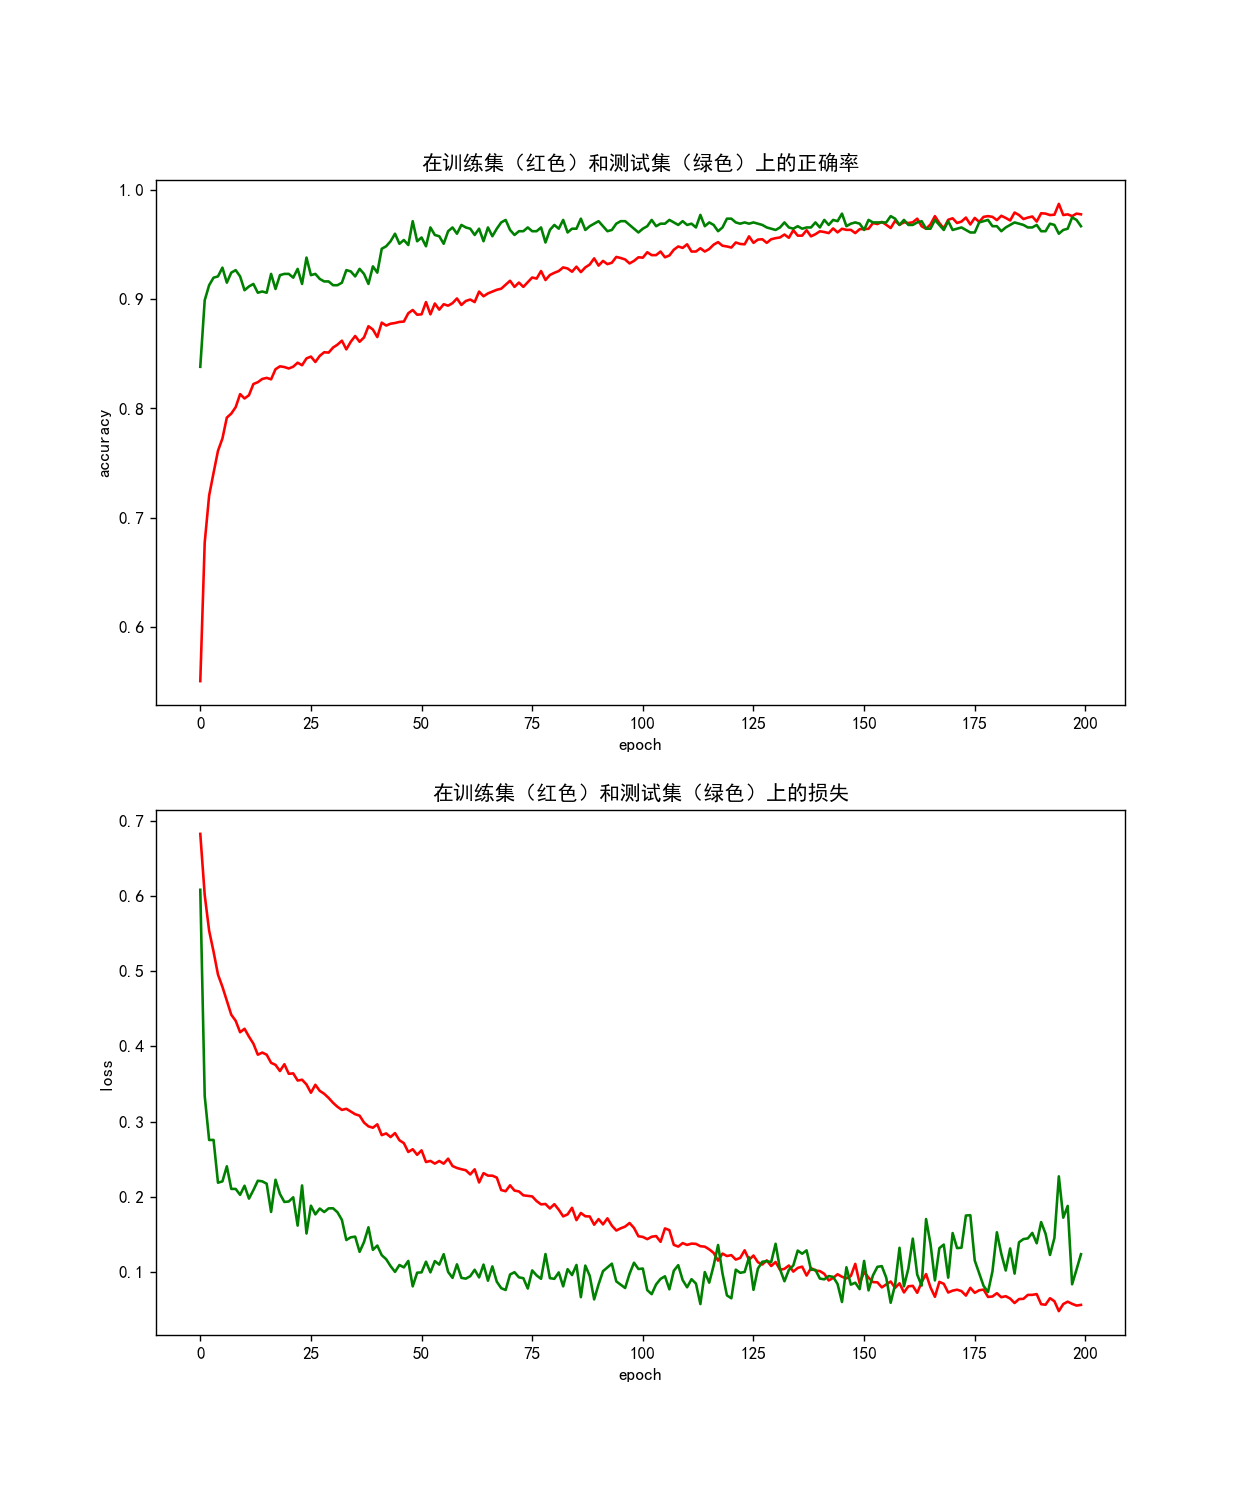

In [8]:
x = [i for i in range(200)]
plt.figure(figsize = (10,12))
plt.subplot(211)
plt.plot(x,acc_list_train,'r',x,acc_list_test,'g')
plt.title('在训练集（红色）和测试集（绿色）上的正确率')
plt.ylabel('accuracy')
plt.xlabel("epoch")

plt.subplot(212)
plt.plot(x,loss_list_train,"r",x,loss_list_test,'g')
plt.title('在训练集（红色）和测试集（绿色）上的损失')
plt.ylabel('loss')
plt.xlabel("epoch")
plt.show()
#plt.savefig('Figure/figureV1.png')

In [10]:
plt.savefig('11.png')

In [11]:
index = acc_list_test.index(max(acc_list_test))

In [12]:
print("Dataset")
print("Accuracy:\t %.4f"%acc_list_test[index])
print("False Positives:",FP_list[index])
print("Fales Negatives:",FN_list[index])
print("Recall:\t\t",Recall_list[index])
print("Precision:\t",Precision_list[index])
print("F-measure:\t",F_list[index])

Dataset
Accuracy:	 0.9782
False Positives: 0.0023
Fales Negatives: 0.0195
Recall:		 0.9388
Precision:	 0.9924
F-measure:	 0.9649


In [13]:
index

145